In [7]:
import pandas as pd
import torch
import torch.nn as nn
import os
import cv2

train_csv_path = './data/training_gt.csv'
val_csv_path = './data/validation_gt.csv'
audio_dir = './data/trainaudiofeat'
video_dir  = './data/trainframes'

csv = pd.read_csv(train_csv_path)
video_name =csv.values[3, 0]
target =csv.values[0, 1:]
audio_path = os.path.join(audio_dir, video_name + ".wav_mt.csv")
video_path = os.path.join(video_dir, video_name.replace(".mp4", ''))
audio_feat = torch.tensor(pd.read_csv(audio_path).values)
video_frames_dir = os.path.join(video_path, video_name.replace(".mp4", '') + '_aligned')
frames_list = os.listdir(video_frames_dir)
frames_list.sort()

a = torch.randint(0, 100, (3,4))
c = (a - a.min()) / (a.max() - a.min())
a, c

(tensor([[29, 47, 19, 98],
         [ 7, 62, 27, 16],
         [78, 17, 23, 53]]),
 tensor([[0.2418, 0.4396, 0.1319, 1.0000],
         [0.0000, 0.6044, 0.2198, 0.0989],
         [0.7802, 0.1099, 0.1758, 0.5055]]))

(3, 112, 112)
(3, 112, 112)
(3, 112, 112)
(3, 112, 112)
(3, 112, 112)
(3, 112, 112)
hM96SfN5_F4.004.mp4
(6, 136)


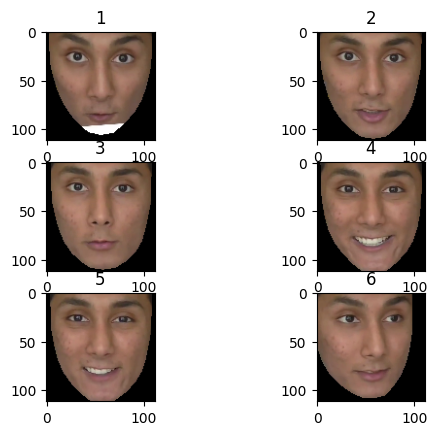

In [14]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
partion_len = len(frames_list) // 6
video_feat = []
for partition in range(6):
    num = torch.randint(partition * partion_len, (partition+1) * partion_len + 1, ())
    img_path = os.path.join(video_frames_dir, frames_list[num])
    img = cv2.imread(img_path).transpose(2, 0, 1)
    print(img.shape)
    video_feat.append(img)
audio_feat = pd.read_csv(audio_path, header = None)
print(video_name)
print(audio_feat.shape)
imgs = torch.tensor(video_feat)
for index in range(6):
    img = imgs[index]
    img = img.permute(1,2,0)
    img = cv2.cvtColor(img.numpy(),cv2.COLOR_BGR2RGB)
    plt.subplot(3,2,index+1)
    plt.imshow(img)
    plt.title("{}".format(index+1))
plt.show()

In [4]:
import json
from datetime import datetime

day = datetime.now().day
hour = datetime.now().hour
print('{}_{}.pth'.format(day, hour))

layer = nn.Sequential(
    nn.Conv2d(3, 16, 5),
    nn.Linear(160, 128)
)
conv = nn.Conv2d(3, 16, 5)
linear = nn.Linear(160, 128)

feat = torch.empty(0)
feat.shape


27_19.pth


torch.Size([0])